# Boston Housing

### Import necessary libraries

First, let’s import the necessary libraries and then load the dataset from csv file

In [9]:
!pip install seaborn # Visualizing library

import pandas as pd
# pandas is a software library written for the Python programming language for data manipulation and analysis.
# In this code we use it to show scatter plots. 
import seaborn as sb 
from matplotlib import pyplot as plt # We use matplotlib for create axe and figures to plot data
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import DoubleType
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col # For use the column name of the dataframe in pyspark
from pyspark.sql import SparkSession

In [12]:
sqlCtx = SparkSession.builder.getOrCreate()

### Import the Dataset

In [10]:
# Here again we use infraschema becouse we need all columns to be double. 

boston_housing = sqlCtx.read.option('header','true').csv('BostonHousing.csv', inferSchema=True)
boston_housing.show()
print(boston_housing.dtypes)

# boston_housing = sqlCtx.read.option('header','true').options(delimiter=",").csv('BostonHousing.csv')
# boston_housing.show()
# print(boston_housing.dtypes)

# for _ in boston_housing.columns:
#     boston_housing = boston_housing.withColumn(_,col(_).cast(DoubleType()))
# print(boston_housing.dtypes)

+-------+----+-----+----+-----+-----+-----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm|  age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+----+-----+----+-----+-----+-----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575| 65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421| 78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185| 61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998| 45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147| 54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|
|0.02985| 0.0| 2.18|   0|0.458| 6.43| 58.7|6.0622|  3|222|   18.7|394.12| 5.21|28.7|
|0.08829|12.5| 7.87|   0|0.524|6.012| 66.6|5.5605|  5|311|   15.2| 395.6|12.43|22.9|
|0.14455|12.5| 7.87|   0|0.524|6.172| 96.1|5.9505|  5|311|   15.2| 396.9|19.15|27.1|
|0.21124|12.5| 7.87|   0|0.524|5.631|100.0|6.0821|  5|311|   15.2

### Attribute Information (in order): 
- **CRIM**     per capita crime rate by town 
- **ZN**       proportion of residential land zoned for lots over 25,000 sq.ft.
- **INDUS**    proportion of non-retail business acres per town
- **CHAS**     Charles River dummy variable (= 1 if tract bounds river, 0 otherwise) 
- **NOX**      nitric oxides concentration (parts per 10 million) 
- **RM**       average number of rooms per dwelling 
- **AGE**      proportion of owner-occupied units built prior to 1940
- **DIS**      weighted distances to five Boston employment centres
- **RAD**      index of accessibility to radial highways
- **TAX**      full-value property-tax rate per 10,000 dollars
- **PTRATIO**  pupil-teacher ratio by town
- **B**        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town 
- **LSTAT**    lower status of the population
- **MEDV**     Median value of owner-occupied homes in $1000's

## Section 2

### Plot heatmap of correlation matrix. 

Select the top three variables based on the pairwise correlations of the variables; 



<AxesSubplot:>

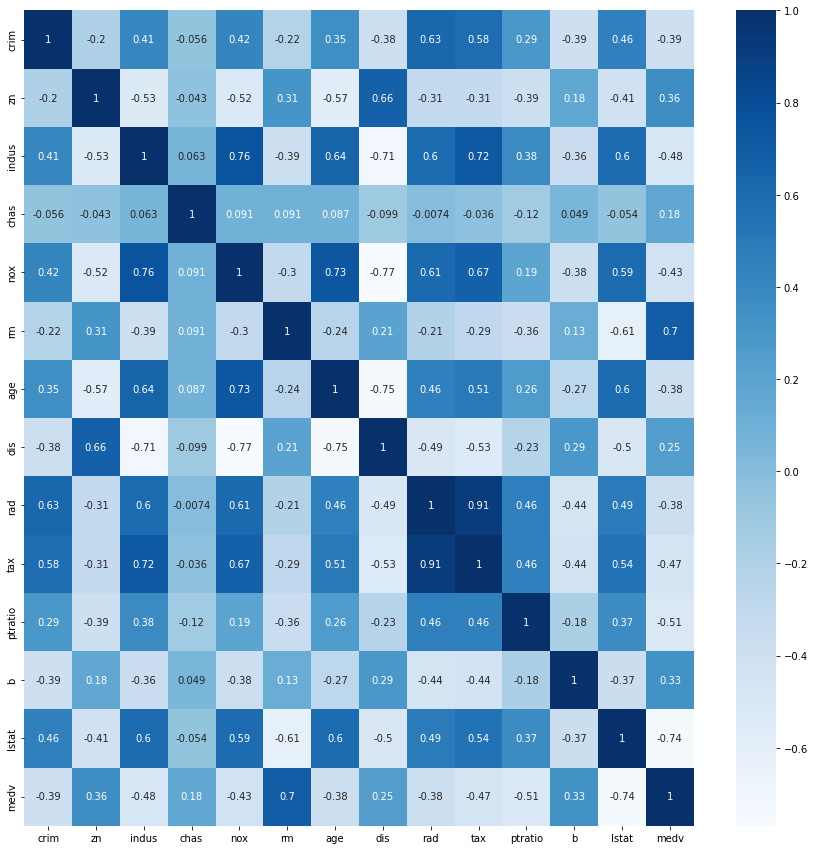

In [13]:
boston_housing_pandas_dataframe = boston_housing.toPandas()

fig, ax = plt.subplots(figsize=(15,15))
sb.heatmap(boston_housing_pandas_dataframe.corr(), cmap="Blues", annot=True, ax=ax)

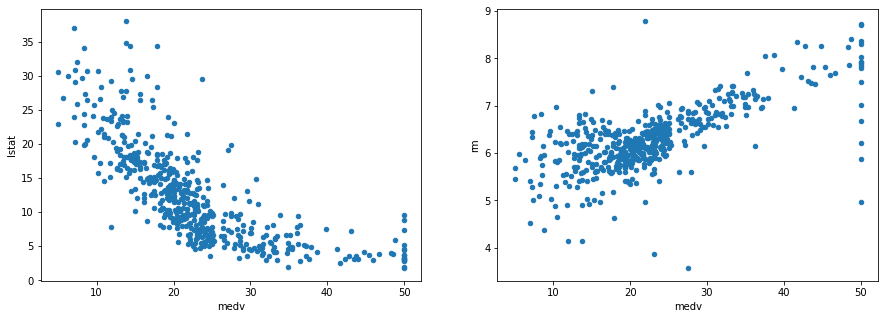

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

boston_housing_pandas_dataframe.plot.scatter(x='medv', y='lstat', ax=ax[0])
boston_housing_pandas_dataframe.plot.scatter(x='medv', y='rm', ax=ax[1])

plt.show()

***The correlation coefficient ranges from –1 to 1. When it is close to 1, it means that there is a strong positive correlation; for example, the median value (MEDV) tends to go up when the number of rooms (RM) goes up. When the coefficient is close to –1, it means that there is a strong negative correlation; the median value (MEDV) tends to go down when the percentage of the lower status of the population (LSTAT) goes up.***

### Section 3
Create a regression model using a polynomial function of degree two on the three selected variables. Use 70% of the data for training;

y = a * x^2 + b * x + c

24 = a * 43.230 + b * 6.575 + c

In [41]:
boston_housing = boston_housing.withColumn("lstat2", col("lstat")*col("lstat"))
boston_housing = boston_housing.withColumn("rm2", col("rm")*col("rm"))

rmAssembler = VectorAssembler(inputCols = ['rm', 'rm2'] , outputCol='rm_features')
lstatAssembler = VectorAssembler(inputCols = ['lstat', 'lstat2'] , outputCol='lstat_features')

df_rm = rmAssembler.transform(boston_housing).select(['medv', 'rm_features'])
df_lstat = lstatAssembler.transform(boston_housing).select(['medv', 'lstat_features'])

df_rm.show()
df_lstat.show()

df_training_lstat, df_test_lstat = df_lstat.randomSplit([0.7, 0.3])
df_training_rm, df_test_rm = df_rm.randomSplit([0.7, 0.3])


+----+--------------------+
|medv|         rm_features|
+----+--------------------+
|24.0|   [6.575,43.230625]|
|21.6|   [6.421,41.229241]|
|34.7|[7.185,51.6242249...|
|33.4|[6.998,48.9720040...|
|36.2|[7.147,51.0796090...|
|28.7|[6.43,41.34489999...|
|22.9|   [6.012,36.144144]|
|27.1|   [6.172,38.093584]|
|16.5|[5.631,31.7081610...|
|18.9|   [6.004,36.048016]|
|15.0|   [6.377,40.666129]|
|18.9|[6.009,36.1080810...|
|21.7|   [5.889,34.680321]|
|20.4|   [5.949,35.390601]|
|18.2|   [6.096,37.161216]|
|19.9|[5.834,34.0355559...|
|23.1|   [5.935,35.224225]|
|17.5|[5.99,35.88010000...|
|20.2|[5.456,29.7679360...|
|18.2|   [5.727,32.798529]|
+----+--------------------+
only showing top 20 rows

+----+--------------------+
|medv|      lstat_features|
+----+--------------------+
|24.0|[4.98,24.80040000...|
|21.6|[9.14,83.53960000...|
|34.7|[4.03,16.24090000...|
|33.4|       [2.94,8.6436]|
|36.2|      [5.33,28.4089]|
|28.7|[5.21,27.14409999...|
|22.9|    [12.43,154.5049]|
|27.1|[19.15,366.72249

#### Create a regression model
maxIter : It is the maximum number of iterations to perform before giving up.

In [42]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

pr = LinearRegression(featuresCol="lstat_features", labelCol="medv", maxIter=30)
prModel = pr.fit(df_training_lstat)


print("Coefficients: " + str(prModel.coefficients))
print("Intercept: " + str(prModel.intercept)) # Describe Intercept 

print("r2:", prModel.summary.r2)

Coefficients: [-2.339275107341796,0.04343323106590465]
Intercept: 43.04724834799953
r2: 0.6343265695055729


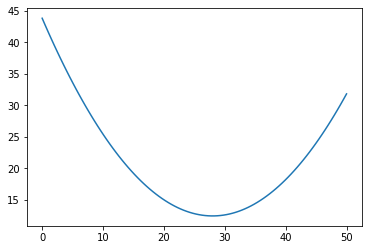

In [43]:
import numpy as np
from matplotlib import pyplot as plt

x = np.linspace(0, 50, 100)
fx = []
for i in range(len(x)):
    fx.append(0.04*x[i]*x[i] - 2.24*x[i] + 43.78)
plt.plot(x, fx)
plt.show()

***R squared at 0.65 indicates that in our model, approximate 65% of the variability in “MV” can be explained using the model.***

### Compute the R-Squared value of the model using the remaining 30% of the test data

In [44]:
pr_predictions = prModel.transform(df_test_lstat)
pr_predictions.show()

pr_predictions.select("prediction", "medv", "lstat_features").show(5)

pr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="medv",metricName="r2")

print("R2 on test data:", pr_evaluator.evaluate(pr_predictions))


+----+--------------------+------------------+
|medv|      lstat_features|        prediction|
+----+--------------------+------------------+
| 8.1|    [29.68,880.9024]|11.878000647804988|
| 8.3|    [19.77,390.8529]|13.775783794331144|
| 8.7|    [26.45,699.6025]| 11.55941879559358|
| 8.8|[30.63,938.196899...|12.144174553135748|
| 9.7|    [25.68,659.4624]|11.617246389938245|
|10.2|[21.78,474.368400...|12.701188837658695|
|10.4|[17.21,296.184100...| 15.65255620399423|
|10.8|[23.79,565.964099...|11.977543074644963|
|10.9|    [14.52,210.8304]|18.238019268313757|
|11.3|       [23.6,556.96]|12.030928189199393|
|11.5|[20.85,434.722500...|13.154765151970814|
|11.8|    [29.29,857.9041]|11.791427461645299|
|12.7|[16.35,267.322500...| 16.41078025457646|
|12.7|[19.01,361.380100...|14.273533943351712|
|13.1|    [17.12,293.0944]|15.728895309630659|
|13.1|[23.69,561.216100...|12.005249604278234|
|13.5|[16.94,286.963600...|15.883684375933335|
|13.6|    [18.07,326.5249]|14.958578588804684|
|13.8|[37.97,

**Sure enough, we achieved worse R squared on the test set.**